# Image Segmentation

Source: https://www.kaggle.com/datasets/tapakah68/segmentation-full-body-tiktok-dancing-dataset/code

In [181]:
# importing libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

tf.random.set_seed(21)
np.random.seed(21)

Loading dataset

In [38]:
# defining the paths
root = os.path.dirname(os.getcwd())
data_path = os.path.join(root,'dataset')
image_path = os.path.join(data_path, 'images')
mask_path = os.path.join(data_path, 'masks')

In [170]:
# assigning files
images = [os.path.join(image_path, i) for i in sorted(os.listdir(image_path))]
masks = [os.path.join(mask_path, i) for i in sorted(os.listdir(mask_path))]

# defining a function to load image
def load_image(image_path, mask_path):
    image, mask = cv2.imread(image_path), cv2.imread(mask_path)
    image, mask = cv2.cvtColor(image, cv2.COLOR_BGR2RGB), cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    image, mask = image.astype(np.float32), mask.astype(np.float32)
    image, mask = image/255.0, mask/255.0
    mask = mask[:,:,[0]]
    mask = tf.keras.utils.to_categorical(mask)
    return image, mask

In [171]:
# number of datapoints
print(f"Number of images = {len(images)}")
print(f"Number of masks = {len(masks)}")

Number of images = 2615
Number of masks = 2615


Visualizing some of the images with their mask

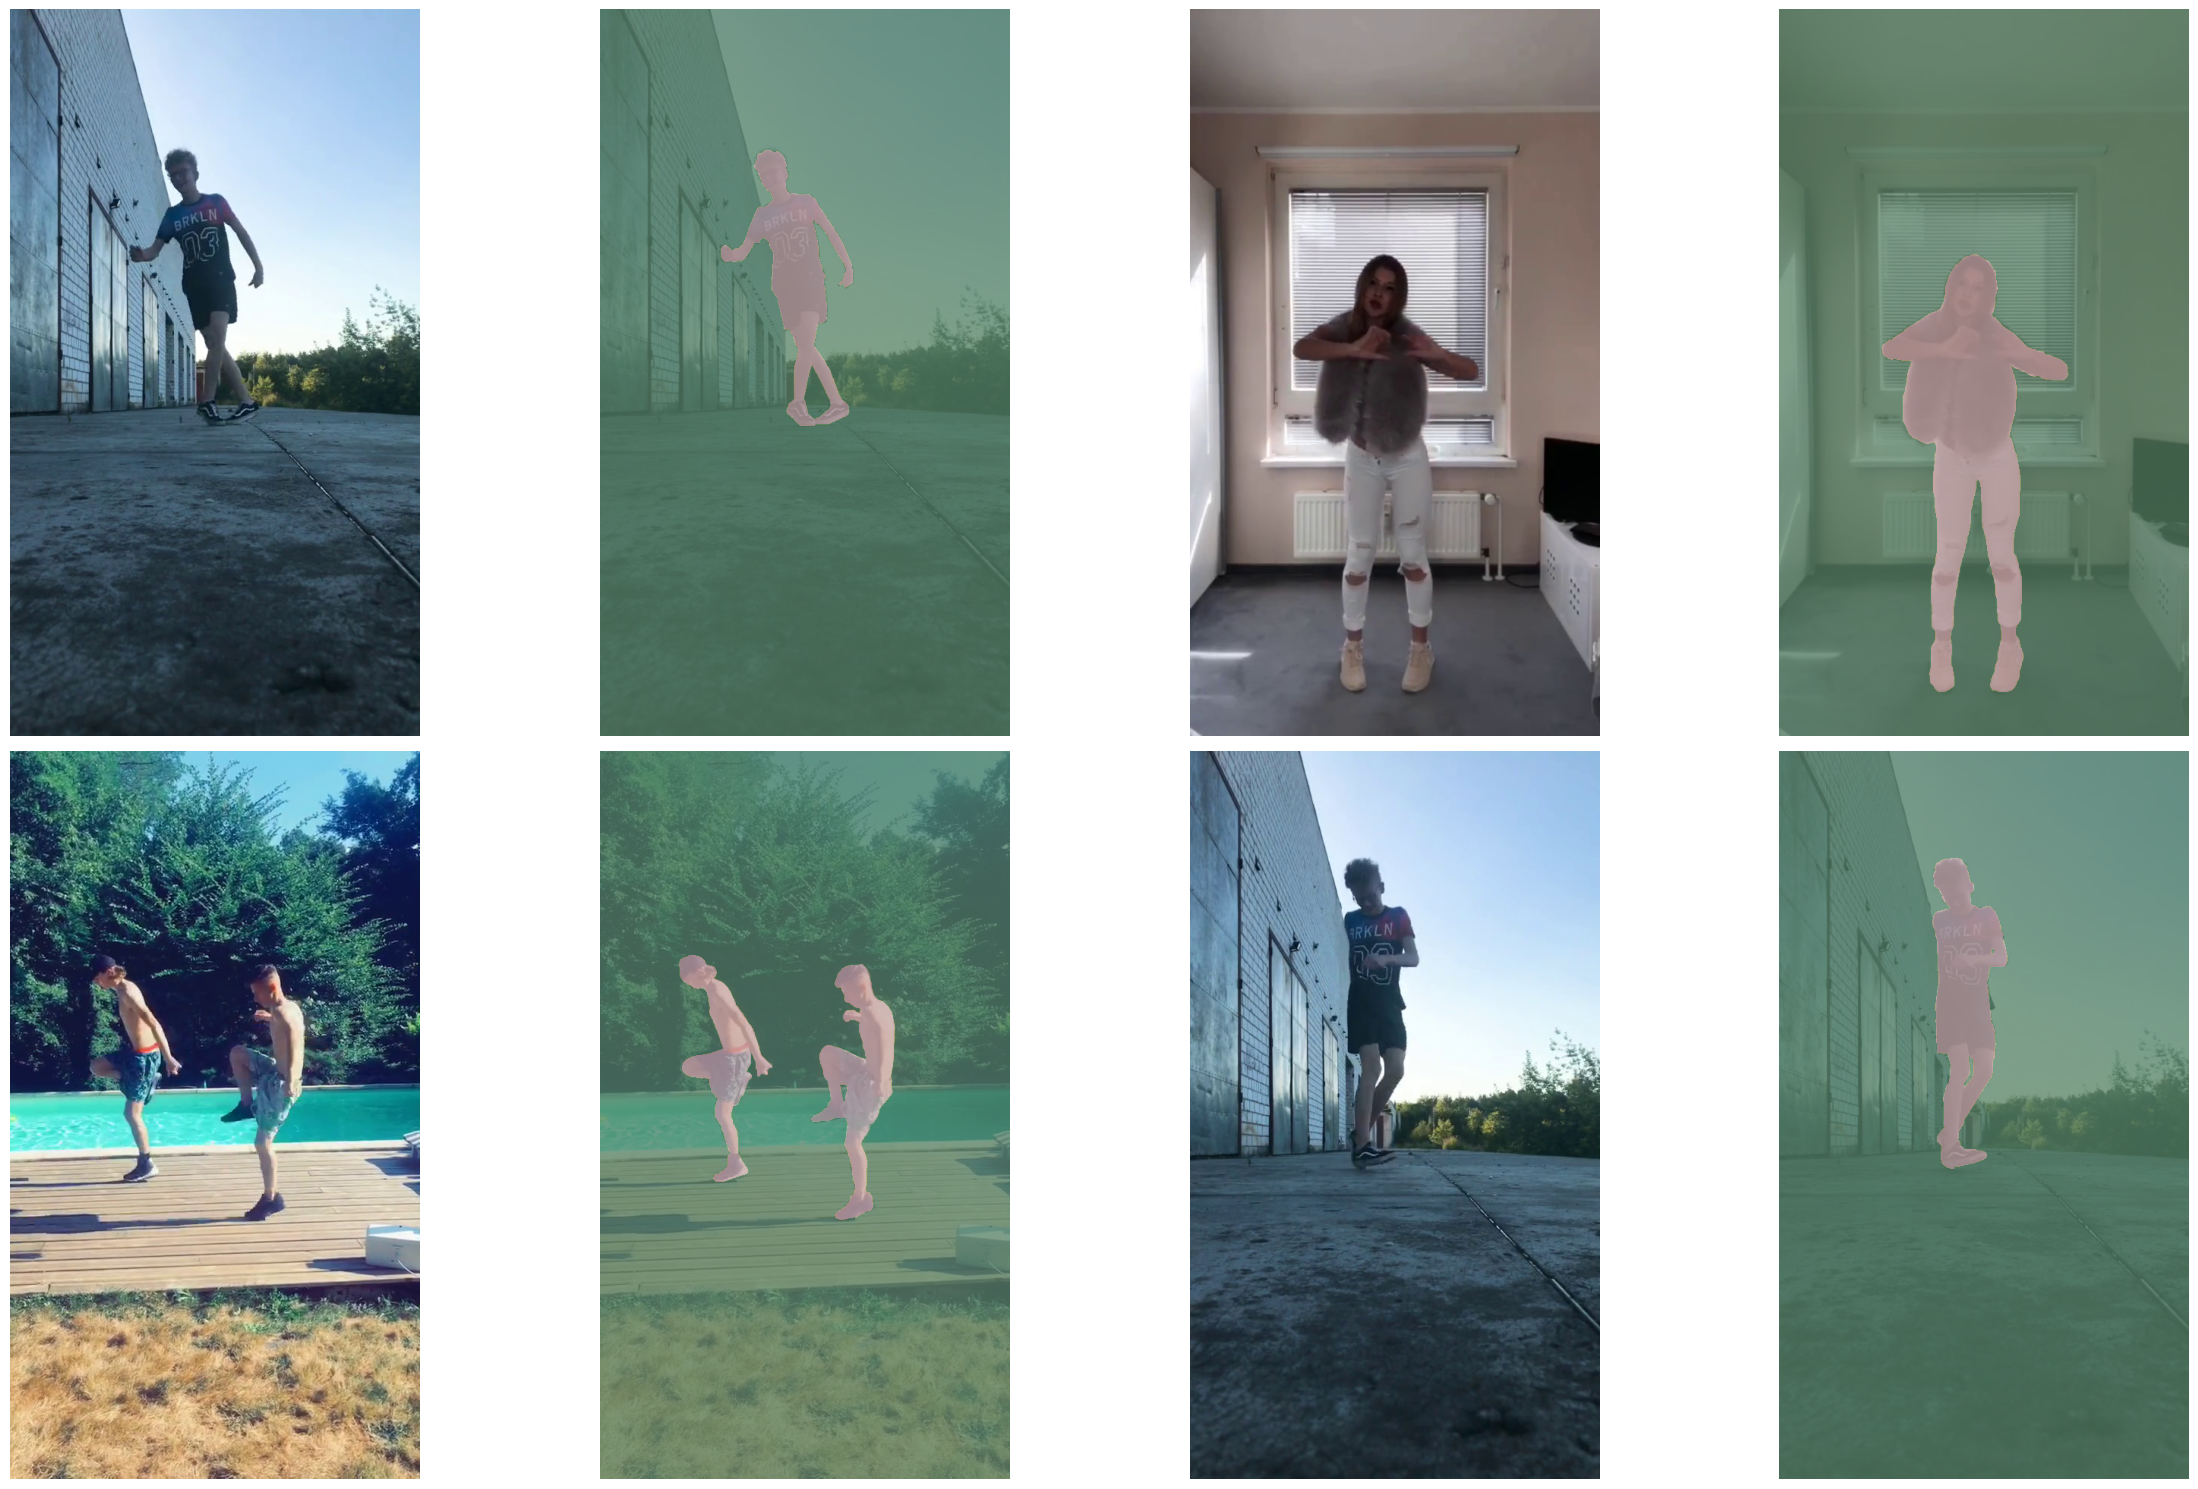

In [173]:
# defining a figure
fig, ax = plt.subplots(2, 4, figsize=(25, 15))
sub = 0
ax_ = ax.ravel()

# picking random images (4)
idx = np.random.choice(range(len(images)), size=4, replace=False)

# plotting each picked image
for i in idx:
    img, msk = load_image(images[i], masks[i])
    # msk = tf.keras.utils.to_categorical(msk)

    ax_[sub].imshow(img)
    ax_[sub].axis('off')
    sub+=1
    ax_[sub].imshow(img)
    ax_[sub].imshow(msk[:,:,1], cmap='Reds', alpha=0.5)
    ax_[sub].imshow(msk[:,:,0], cmap='Greens', alpha=0.5)
    ax_[sub].axis('off')
    sub+=1

plt.tight_layout()
plt.show()

## Modelling

In [15]:
# splitting the data
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(images, masks, test_size=0.2, shuffle=True, random_state=21)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.2, shuffle=True, random_state=42)

In [17]:
# number of images in each dataset
print(len(xtrain))
print(len(xval))
print(len(xtest))

1673
419
523


Defining the datasets

In [204]:
# defining a class to generate batches of images and masks
class ImageGenerator(tf.keras.utils.Sequence):
    
    # initializer
    def __init__(self, x, y, size, batch_size):
        self.x = x
        self.y = y
        self.size = size
        self.batch_size = batch_size
        
    # defining the length representing the number of batchs
    def __len__(self):
        return int(np.ceil(len(self.x)/self.batch_size))
    
    # defning the get item method to return a batch of data
    def __getitem__(self, idx):
        low = idx*self.batch_size
        batch_x = self.x[low : low + self.batch_size]
        batch_y = self.y[low : low + self.batch_size]
        
        batch_images = []
        for i in batch_x:
            img = Image.open(i)
            img = img.resize(self.size)
            img = np.array(img)/255.0
            batch_images.append(img)
        batch_images = np.array(batch_images)
        
        batch_masks = []
        for i in batch_y:
            msk = Image.open(i).convert('L')
            msk = msk.resize(self.size)
            msk = np.array(msk)/255.0
            batch_masks.append(msk)
        batch_masks = np.array(batch_masks)
        
        return batch_images, batch_masks

In [205]:
train = ImageGenerator(xtrain, ytrain, (128,256), 32)
val = ImageGenerator(xval, yval, (128,256), 32)

In [25]:
# # defining a function to load images in tensorflow
# def load_image_tf(image_path, mask_path):
#     image, mask = tf.io.read_file(image_path), tf.io.read_file(mask_path)
#     image, mask = tf.image.decode_png(image), tf.image.decode_png(mask, channels=1)
#     image, mask = tf.image.convert_image_dtype(image, tf.float32), tf.image.convert_image_dtype(mask, tf.float32)
#     image, mask = tf.image.resize(image, (256,128)), tf.image.resize(mask, (256,128), method='nearest')
#     return (image, mask)

In [206]:
# train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
# val = tf.data.Dataset.from_tensor_slices((xval, yval))
# test = tf.data.Dataset.from_tensor_slices((xtest, ytest))

# train = train.map(load_image_tf).shuffle(len(images)).batch(32).prefetch(1)
# val = val.map(load_image_tf).batch(32).prefetch(1)
# test = test.map(load_image_tf).batch(1)

### Fully convolutional network

In [207]:
# defining the fully convolutional network from scratch

def FCN():

    # defining a backbone architecture to generate embeddings from out image
    backbone = tf.keras.applications.VGG16(
        weights='imagenet',
        include_top=False,
        input_tensor=tf.keras.Input(shape=(256,128,3))
    )
    backbone.trainable=False # setting the backbone to be non-trainable
    x = backbone(backbone.input, training=False) # setting training=False to run only in inference mode

    # adding more convolutions
    x = tf.keras.layers.Conv2D(4096, kernel_size=(7,7), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(4096, kernel_size=(1,1), activation='relu', padding='same', name='encoder_out')(x)

    # decoder architecture

    # step 1
    # the output from the encoder is of the shape (4,4,4096)
    # we need to upsample it to a face size of (16,16) in order to make redidual connections
    o = tf.keras.layers.Conv2DTranspose(2, kernel_size=(4,4), strides=(4,4), use_bias=False)(x)

    # step 2
    # getting the output from intermediate layers of the backbone to add to upsampled feature map
    pool4_out = backbone.get_layer('block4_pool').output    #  this will be of the shape (8,8,512)
    pool4_out = tf.keras.layers.Conv2D(2, kernel_size=(1,1), activation='relu', padding='same')(pool4_out)
    pool4_out = tf.keras.layers.Conv2DTranspose(2, kernel_size=(2,2), strides=(2,2), use_bias=False)(pool4_out)

    pool3_out = backbone.get_layer('block3_pool').output    # this will be of the shape (16,16,256)
    pool3_out = tf.keras.layers.Conv2D(2, kernel_size=(1,1), activation='relu', padding='same')(pool3_out)

    res_con = tf.keras.layers.Add()([pool3_out, pool4_out])

    # step 3
    # adding the residual connection to the upsampled feature map
    o = tf.keras.layers.Add()([o, res_con])

    # step 4
    # upsampling the feature map to the size same as input image
    o = tf.keras.layers.Conv2DTranspose(1, kernel_size=(8,8), strides=(8,8), use_bias=False)(o)

    # applying softmax activation
    o = tf.keras.layers.Activation('sigmoid')(o)

    # defining the model end to end
    model = tf.keras.Model(backbone.input, o)

    return model

In [208]:
fcn = FCN()
fcn.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 128, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 128, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 128, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 64, 64)          0         ['block1_conv2[0][0]']        
                                                                                            

Defining a function to calculate dice coefficient

In [209]:
def dice_coeff(ytrue,ypred,smoothing=1):
    # flattening the y arrays
    ytruef = tf.keras.backend.flatten(ytrue)
    ypredf = tf.keras.backend.flatten(ypred)
    intersection = tf.keras.backend.sum(ytruef*ypredf)
    coef = (2*intersection + smoothing)/(tf.keras.backend.sum(ytruef)+tf.keras.backend.sum(ypredf)+smoothing)
    return coef

In [210]:
fcn.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy',dice_coeff]
)

Setting up tensorboard

In [211]:
# log_dir = os.path.join(root, 'logs')
# if not os.path.isdir(log_dir):
#     os.mkdir(log_dir)

# %load_ext tensorboard
# import datetime
# !rm -rf log_dir
# log_path = os.path.join(log_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M"))

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_path)

# print(f"Log path: {log_path}")

Train the FCN model

In [212]:
history = fcn.fit(train, validation_data=val, epochs=1) #, callbacks=[tensorboard_callback]

53/53 [==============================] - 316s 6s/step - loss: 0.7178 - accuracy: 0.5429 - dice_coeff: 0.1641 - val_loss: 0.5961 - val_accuracy: 0.6238 - val_dice_coeff: 0.1877


In [ ]:
# %tensorboard --logdir log_dir

Checking the predictions on val data

In [ ]:
# def check_perf(xval, yval, model):
#     yprob = model.predict(xval)
#     ypred = np.argmax(yprob, axis=-1)
#     ytrue = np.argmax(ytrue, axis=-1)

#     fig, ax = plt.subplots(5, 3, figsize=(20, 30))
#     ax_ = ax.ravel()
#     sub = 1

#     ax_[0].set_title('Image')
#     ax_[1].set_title('Ground truth region')
#     ax_[2].set_title('Predicted region')

#     idx = np.random.choice(range(xval.shape[0]), size=5, replace=False)

#     for i in idx:
#         ax_[sub].imshow(xval[i])
#         sub+=1
#         ax_[sub].imshow(xval[i])
#         ax_[sub].imshow(ytrue[i], alpha=0.5)
#         sub+=1
#         ax_[sub].imshow(xval[i])
#         ax_[sub].imshow(ypred[i], alpha=0.5)

#     plt.axis('off')
#     plt.tight_layout()
#     plt.show()

In [ ]:
# check_perf(xval, yval, fcn)

### UNET

In [217]:
def UNET():

    # encoder block 1
    input = tf.keras.layers.Input(shape=(256,128,3))
    conv1 = tf.keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu')(input)
    conv1 = tf.keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu')(conv1)
    maxp1 = tf.keras.layers.MaxPooling2D(pool_size=2)(conv1)

    # encoder block 2
    conv2 = tf.keras.layers.Conv2D(128, kernel_size=(3,3), padding='same', activation='relu')(maxp1)
    conv2 = tf.keras.layers.Conv2D(128, kernel_size=(3,3), padding='same', activation='relu')(conv2)
    maxp2 = tf.keras.layers.MaxPooling2D(pool_size=2)(conv2)

    # encoder block 3
    conv3 = tf.keras.layers.Conv2D(256, kernel_size=(3,3), padding='same', activation='relu')(maxp2)
    conv3 = tf.keras.layers.Conv2D(256, kernel_size=(3,3), padding='same', activation='relu')(conv3)
    maxp3 = tf.keras.layers.MaxPooling2D(pool_size=2)(conv3)

    # encoder block 4
    conv4 = tf.keras.layers.Conv2D(512, kernel_size=(3,3), padding='same', activation='relu')(maxp3)
    conv4 = tf.keras.layers.Conv2D(512, kernel_size=(3,3), padding='same', activation='relu')(conv4)
    maxp4 = tf.keras.layers.MaxPooling2D(pool_size=2)(conv4)

    # encoder block 5
    conv5 = tf.keras.layers.Conv2D(1024, kernel_size=(3,3), padding='same', activation='relu')(maxp4)
    conv5 = tf.keras.layers.Conv2D(1024, kernel_size=(3,3), padding='same', activation='relu')(conv5)

    # decoder block 1
    convup1 = tf.keras.layers.UpSampling2D(size=2)(conv5)
    convup1 = tf.keras.layers.Conv2D(512, kernel_size=(3,3), padding='same', activation='relu')(convup1)
    convup1 = tf.keras.layers.Concatenate()([convup1, conv4])
    convup1 = tf.keras.layers.Conv2D(512, kernel_size=(3,3), padding='same', activation='relu')(convup1)

    # decoder block 2
    convup2 = tf.keras.layers.UpSampling2D(size=2)(convup1)
    convup2 = tf.keras.layers.Conv2D(256, kernel_size=(3,3), padding='same', activation='relu')(convup2)
    convup2 = tf.keras.layers.Concatenate()([convup2, conv3])
    convup2 = tf.keras.layers.Conv2D(256, kernel_size=(3,3), padding='same', activation='relu')(convup2)

    # decoder block 3
    convup3 = tf.keras.layers.UpSampling2D(size=2)(convup2)
    convup3 = tf.keras.layers.Conv2D(128, kernel_size=(3,3), padding='same', activation='relu')(convup3)
    convup3 = tf.keras.layers.Concatenate()([convup3, conv2])
    convup3 = tf.keras.layers.Conv2D(128, kernel_size=(3,3), padding='same', activation='relu')(convup3)

    # decoder block 4
    convup4 = tf.keras.layers.UpSampling2D(size=2)(convup3)
    convup4 = tf.keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu')(convup4)
    convup4 = tf.keras.layers.Concatenate()([convup4, conv1])
    convup4 = tf.keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu')(convup4)

    # output
    output = tf.keras.layers.Conv2D(1, kernel_size=(3,3), padding='same', activation='sigmoid')(convup4)

    # defining the keras model
    model = tf.keras.Model(input, output)

    return model

In [218]:
unet = UNET()
unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 128, 3)]        0         []                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 256, 128, 64)         1792      ['input_5[0][0]']             
                                                                                                  
 conv2d_27 (Conv2D)          (None, 256, 128, 64)         36928     ['conv2d_26[0][0]']           
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 128, 64, 64)          0         ['conv2d_27[0][0]']           
 g2D)                                                                                       

In [219]:
# # defining callbacks

# log_path = os.path.join(log_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_path)

In [220]:
# compiling the unet model
unet.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy',dice_coeff]
)

In [221]:
history = unet.fit(train, validation_data=val, epochs=1) #, callbacks=[tensorboard_callback]

53/53 [==============================] - 796s 15s/step - loss: 1.4369 - accuracy: 0.8922 - dice_coeff: 0.0060 - val_loss: 1.5914 - val_accuracy: 0.8858 - val_dice_coeff: 1.7133e-05


In [ ]:
# %tensorboard --logdir log_dir

In [ ]:
# check_perf(xval, yval, unet)